In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.ops import box_iou
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
import pandas as pd
import numpy as np

In [39]:

from pycocotools.coco import COCO

In [40]:
from albumentations.pytorch import ToTensorV2

In [41]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [42]:
class Data(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):

        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [43]:
# !curl -L "https://public.roboflow.com/ds/9MYy0P1ctc?key=bva5WQfEFB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


In [44]:
dataset_path = r"C:\Code\Giao thong viet nam.v2i.coco"

In [45]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


{0: {'id': 0, 'name': 'A', 'supercategory': 'none'},
 1: {'id': 1, 'name': '0verhead electrical cables', 'supercategory': 'A'},
 2: {'id': 2, 'name': 'Bicycle ban', 'supercategory': 'A'},
 3: {'id': 3, 'name': 'Bus Stop', 'supercategory': 'A'},
 4: {'id': 4, 'name': 'Cars ban', 'supercategory': 'A'},
 5: {'id': 5, 'name': 'Compulsary ahead', 'supercategory': 'A'},
 6: {'id': 6, 'name': 'Compulsory keep left', 'supercategory': 'A'},
 7: {'id': 7, 'name': 'Compulsory keep right', 'supercategory': 'A'},
 8: {'id': 8, 'name': 'Containers ban', 'supercategory': 'A'},
 9: {'id': 9, 'name': 'Dangerous Turn', 'supercategory': 'A'},
 10: {'id': 10, 'name': 'Left Turn', 'supercategory': 'A'},
 11: {'id': 11, 'name': 'Motobike ban', 'supercategory': 'A'},
 12: {'id': 12, 'name': 'Motobike ban1', 'supercategory': 'A'},
 13: {'id': 13, 'name': 'Motorcycles Only', 'supercategory': 'A'},
 14: {'id': 14, 'name': 'No Passenger Cars and Trucks', 'supercategory': 'A'},
 15: {'id': 15,
  'name': 'No Two o

In [46]:
classes = [i[1]['name'] for i in categories.items()]
classes

['A',
 '0verhead electrical cables',
 'Bicycle ban',
 'Bus Stop',
 'Cars ban',
 'Compulsary ahead',
 'Compulsory keep left',
 'Compulsory keep right',
 'Containers ban',
 'Dangerous Turn',
 'Left Turn',
 'Motobike ban',
 'Motobike ban1',
 'Motorcycles Only',
 'No Passenger Cars and Trucks',
 'No Two or Three-wheeled Vehicles',
 'No U-Turn and No turn right',
 'No U-turn',
 'No U-turn No turn left',
 'No car turn left',
 'No car turn right',
 'No parking',
 'No parking stopping',
 'No turn left',
 'No turn right',
 'One way',
 'Packing',
 'Pedestrian crossing sign',
 'Pedestrians prohibited',
 'Priority sign',
 'Prohibiting pedestrians',
 'Slowly',
 'Speed -limit 40',
 'Speed -limit 50',
 'Speed -limit 60',
 'Speed -limit 80',
 'U-Turn Allowed',
 'Watch for children',
 'Yield sign']

In [47]:
train_dataset = Data(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


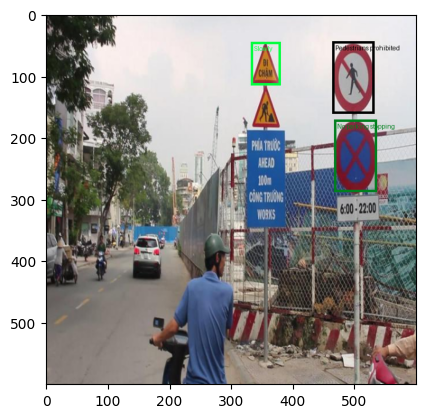

In [48]:
sample = train_dataset[4]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [49]:
len(train_dataset)

5360

In [61]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [51]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [62]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [63]:

images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [54]:
device = torch.device("cuda")
# device= "cpu"

In [60]:
model = model.to(device)

In [64]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [71]:
def train_one_epoch(model, optimizer, scheduler, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []
    all_ious = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        # Forward pass, compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        # Check for infinite loss
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Compute IoU for each image in the batch
        with torch.no_grad():
            model.eval()  # Switch to evaluation mode for inference
            outputs = model(images)  # Get predictions
            model.train()  # Switch back to training mode

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].detach().cpu()  # Predicted boxes
                target_boxes = target['boxes'].detach().cpu()  # Ground truth boxes
                if pred_boxes.size(0) > 0 and target_boxes.size(0) > 0:
                    ious = box_iou(pred_boxes, target_boxes)  # Calculate IoU between all pairs
                    avg_iou = ious.diag().mean().item()  # Diagonal elements are IoUs for matching pairs
                else:
                    avg_iou = 0
                all_ious.append(avg_iou)

    # Calculate the average loss and IoU for the epoch
    avg_loss = np.mean(all_losses)
    avg_iou = np.mean(all_ious) if all_ious else 0

    # Step the learning rate scheduler based on the average loss for the epoch
    scheduler.step(avg_loss)

    # Get the current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Print average losses, IoU, and learning rate
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}, IoU: {:.4f}".format(
        epoch, current_lr, avg_loss,
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean(),
        avg_iou
    ))

In [ ]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch)
    

In [ ]:
torch.save(model, 'fasterrcnn_model.pth')

In [ ]:
model1 = torch.load('fasterrcnn_model.pth')
model1.eval() 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
model1.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = Data(root=dataset_path, split="valid", transforms=get_transforms(False))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:


model.eval()

# Initialize lists to store evaluation metrics
iou_scores = []
precision_scores = []
recall_scores = []

@torch.no_grad()
def evaluate(model, loader, device):
    model.to(device)
    model.eval()

    for images, targets in tqdm(loader):
        # Move images and targets to the specified device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass: Get predictions
        outputs = model(images)
        
        # Process each image in the batch (batch size is set to 1 for testing)
        for i, output in enumerate(outputs):
            pred_boxes = output['boxes'].cpu()  # Predicted bounding boxes
            pred_labels = output['labels'].cpu()  # Predicted labels
            
            # Target (ground truth) boxes and labels
            gt_boxes = targets[i]['boxes'].cpu()
            gt_labels = targets[i]['labels'].cpu()
            
            # Calculate IoU (Intersection over Union) between each pair of predicted and GT boxes
            iou_matrix = box_iou(pred_boxes, gt_boxes)
            max_ious, max_iou_indices = iou_matrix.max(dim=1)
            iou_scores.extend(max_ious.tolist())
            
            # Calculate Precision and Recall
            tp = (max_ious > 0.5).sum().item()  # True Positives
            fp = len(pred_boxes) - tp  # False Positives
            fn = len(gt_boxes) - tp  # False Negatives
            
            precision = tp / (tp + fp + 1e-6) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn + 1e-6) if (tp + fn) > 0 else 0.0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
    
    # Calculate average metrics
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    
    # Print the evaluation results
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")

# Evaluate the model on the test set
evaluate(model, test_loader, device)

100%|██████████| 22/22 [00:36<00:00,  1.67s/it]

Average IoU: 0.5919
Average Precision: 0.7721
Average Recall: 1.1967


In [ ]:
img, _ = test_dataset[1]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model1([img.to(device)])
    pred = prediction[0]

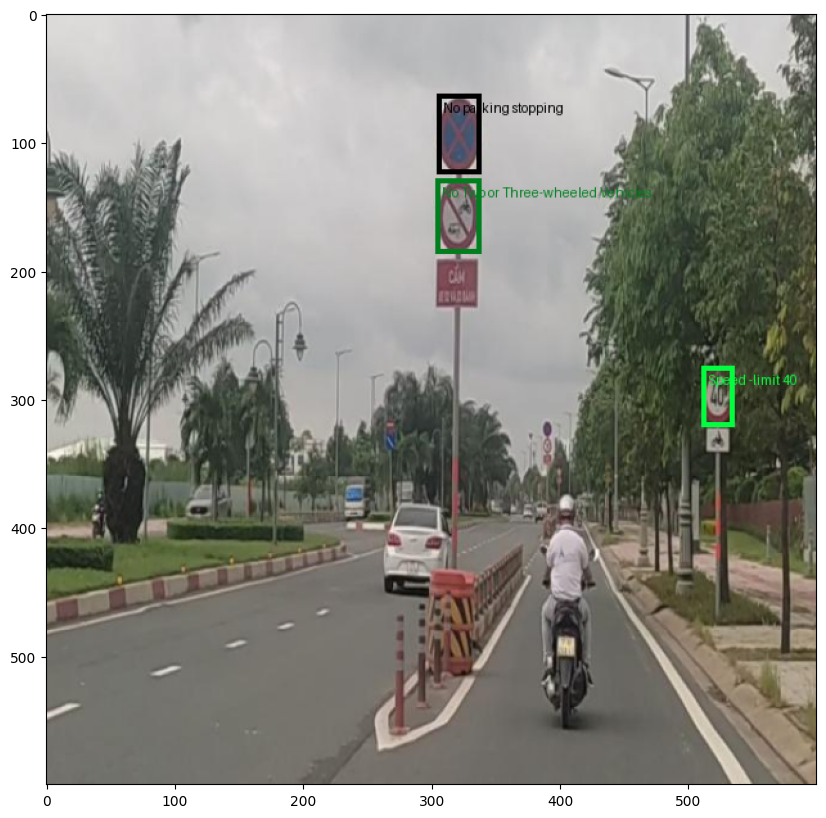

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))